In [1]:
import numpy as np
import matplotlib.pyplot as plt

ncells = 1000  # Number of cells



xmus = [0, 5, 5]
xsds = [1, 0.1, 1]
ymus = [5, 5, 0]
ysds = [1, 0.1, 1]

prop1 = [0.3, 0.5, 0.2]
comp1 = np.random.choice([1, 2, 3], p=prop1, size=ncells, replace=True)


np.random.seed(0)

samples1 = np.column_stack((np.random.normal(loc=np.array(xmus)[comp1-1], scale=np.array(xsds)[comp1-1], size=ncells),
                            np.random.normal(loc=np.array(ymus)[comp1-1], scale=np.array(ysds)[comp1-1], size=ncells)))
ngenes = 100
np.random.seed(0)
proj = np.random.normal(size=(ngenes, 2))

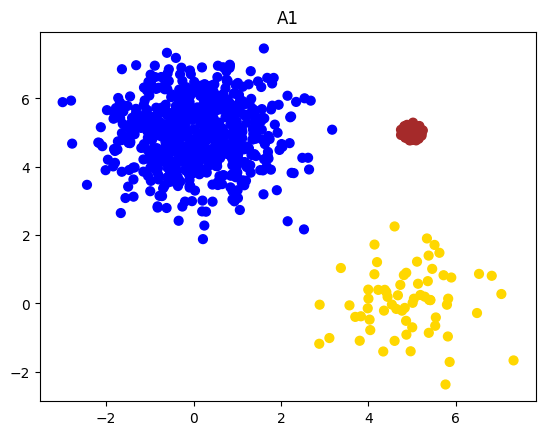

In [2]:
easy_values = [False, True]

prop2 = [0.65, 0.3, 0.05]

# Setting proportions of each of the three cell types in batch 2.
comp2 = np.random.choice([1, 2, 3], p=prop2, size=ncells, replace=True)
samples2 = np.column_stack((np.random.normal(loc=np.array(xmus)[comp2-1], scale=np.array(xsds)[comp2-1], size=ncells),
                            np.random.normal(loc=np.array(ymus)[comp2-1], scale=np.array(ysds)[comp2-1], size=ncells)))
ref_cols = ["blue", "brown", "gold"]
clust1 = [ref_cols[i-1] for i in comp2]

plt.scatter(samples2[:, 0], samples2[:, 1], marker='o', s=40, c=clust1)

plt.title('A1')
plt.show()

X1 = np.dot(samples2, proj.T)

#A2 = np.transpose(A2)
row_names = [f"Cell{i+1}-1" for i in range(ncells)]
col_names = [f"Gene{i+1}" for i in range(ngenes)]


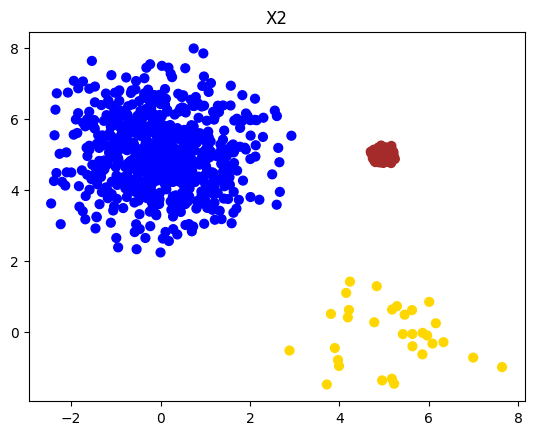

In [3]:
easy_values = [False, True]

prop2 = [0.65, 0.3, 0.05]

# Setting proportions of each of the three cell types in batch 2.
comp2 = np.random.choice([1, 2, 3], p=prop2, size=ncells, replace=True)
samples2 = np.column_stack((np.random.normal(loc=np.array(xmus)[comp2-1], scale=np.array(xsds)[comp2-1], size=ncells),
                            np.random.normal(loc=np.array(ymus)[comp2-1], scale=np.array(ysds)[comp2-1], size=ncells)))
ref_cols = ["blue", "brown", "gold"]
clust2 = [ref_cols[i-1] for i in comp2]

plt.scatter(samples2[:, 0], samples2[:, 1], marker='o', s=40, c=clust2)

plt.title('X2')
plt.show()

X2 = np.dot(samples2, proj.T)

#A2 = np.transpose(A2)
row_names = [f"Cell{i+1}-1" for i in range(ncells)]
col_names = [f"Gene{i+1}" for i in range(ngenes)]


In [4]:
import numpy
def total_correlation(X1, X2, k):
    r1 = 1e-4
    r2 = 1e-4

    n1 = X1.shape[1] 
    n2 = X2.shape[1]
    m = X1.shape[0] #number of rows

    mean1 = numpy.mean(X1, axis=0)
    mean2 = numpy.mean(X2, axis=0)

    H1bar = X1 - numpy.tile(mean1, (m, 1))
    H2bar = X2 - numpy.tile(mean2, (m, 1))


    SigmaHat12 = (1.0 / (m - 1)) * numpy.dot(H1bar.T, H2bar)
    SigmaHat11 = (1.0 / (m - 1)) * numpy.dot(H1bar.T, H1bar) + r1 * numpy.identity(n1)
    SigmaHat22 = (1.0 / (m - 1)) * numpy.dot(H2bar.T, H2bar) + r2 * numpy.identity(n2)


    [D1, V1] = numpy.linalg.eigh(SigmaHat11) #Eigendecomposition for easy inversion
    [D2, V2] = numpy.linalg.eigh(SigmaHat22) #Eigendecomposition for easy inversion
    SigmaHat11RootInv = numpy.dot(numpy.dot(V1, numpy.diag(D1 ** -0.5)), V1.T) #
    SigmaHat22RootInv = numpy.dot(numpy.dot(V2, numpy.diag(D2 ** -0.5)), V2.T)
    T = numpy.dot(numpy.dot(SigmaHat11RootInv, SigmaHat12), SigmaHat22RootInv)
    

    [U, D, V] = numpy.linalg.svd(T)
    V = V.T
    A1star = numpy.dot(SigmaHat11RootInv, U[:, 0:k])
    A2star = numpy.dot(SigmaHat22RootInv, V[:, 0:k])
    D = D[0:k]

    top_k_singular_values = D[:k]

    total_corr = numpy.sum(D)

    return A1star, total_corr, A2star

In [5]:
A1, total_corr, A2 = total_correlation(X1, X2, k=10)

In [6]:
total_corr

0.03953517582858162

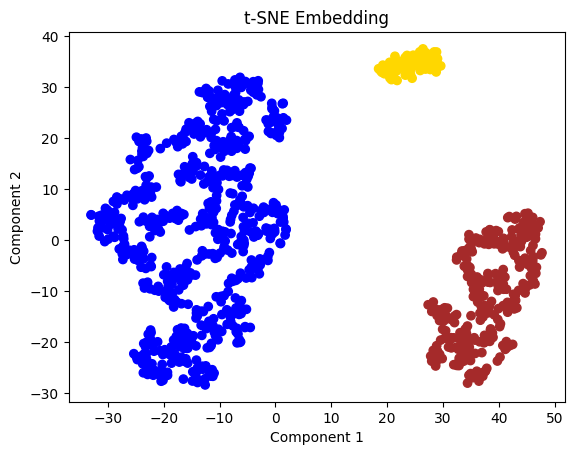

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_embedded = TSNE(n_components=2).fit_transform((X1 @ A1))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=clust1)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Embedding')
plt.show()


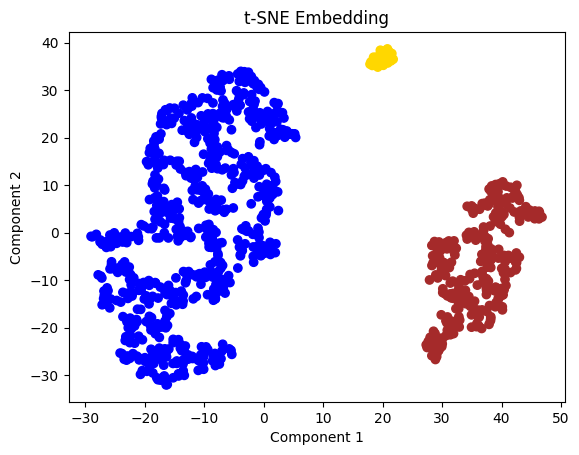

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_embedded = TSNE(n_components=2).fit_transform((X2 @ A2))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=clust2)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Embedding')
plt.show()


In [9]:
X1.shape

(1000, 100)

In [10]:
X2.shape

(1000, 100)

In [52]:


import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout, LeakyReLU, BatchNormalization
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from dcca import  CCA
from keras.optimizers import Adam, RMSprop

def constant_loss(y_true, y_pred):
    return y_pred

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)


#train_set_x1, valid_set_x1, train_set_x2, valid_set_x2 = train_test_split(X, Y, test_size=0.20)

# size of the input for view 1 and view 2
input_shape1 = 100
input_shape2 = 100

# network settings
epoch_num = 10


batch_size = 20
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization

#load data


input1 = Input(shape=(input_shape1, ), name='input1')
input2 = Input(shape=(input_shape2, ), name='input2')

expert_index = 0
# Definicja funkcji aktywacji
activation_model ='linear'

# Warstwy wejściowe
input1 = Input(shape=(input_shape1,))
input2 = Input(shape=(input_shape2,))

# Warstwy gęste dla widoku 1
normalizaction_1 = BatchNormalization()(input1)
dense1_1 = Dense(10, activation=activation_model, name='view_1_1')(normalizaction_1)
output1 = Dense(5, activation='linear', name='view_1_4')(dense1_1)

# Warstwy gęste dla widoku 2
normalizaction_2 = BatchNormalization()(input2)
dense2_1 = Dense(10, activation=activation_model, name='view_2_1')(normalizaction_2)
output2 = Dense(5, activation='linear', name='view_2_4')(dense2_1)

# Warstwa łącząca
shared_layer = concatenate([output1, output2], name='shared_layer')

# Normalizacja danych
shared_layer = BatchNormalization()(shared_layer)

cca_layer = CCA(1, name='cca_layer')(shared_layer)

model = Model(inputs=[input1, input2], outputs=cca_layer)
model.compile(optimizer=RMSprop(lr=0.0001), loss=constant_loss, metrics=[mean_pred])
model.fit([X1, X2], np.zeros(len(X1)),
          batch_size=batch_size, epochs=epoch_num, shuffle=True, verbose=1)



Epoch 1/10
50/50 [==============================] - 3s 5ms/step - loss: -0.9604 - mean_pred: -0.9604
Epoch 2/10
50/50 [==============================] - 0s 6ms/step - loss: -0.9196 - mean_pred: -0.9196
Epoch 3/10
50/50 [==============================] - 0s 4ms/step - loss: -0.9073 - mean_pred: -0.9073
Epoch 4/10
50/50 [==============================] - 0s 5ms/step - loss: -0.9218 - mean_pred: -0.9218
Epoch 5/10
50/50 [==============================] - 0s 4ms/step - loss: -0.8839 - mean_pred: -0.8839
Epoch 6/10
50/50 [==============================] - 0s 5ms/step - loss: -0.9600 - mean_pred: -0.9600
Epoch 7/10
50/50 [==============================] - 0s 5ms/step - loss: -0.9416 - mean_pred: -0.9416
Epoch 8/10
50/50 [==============================] - 0s 6ms/step - loss: -0.9757 - mean_pred: -0.9757
Epoch 9/10
50/50 [==============================] - 0s 6ms/step - loss: -0.8884 - mean_pred: -0.8884
Epoch 10/10
50/50 [==============================] - 0s 7ms/step - loss: -0.9531 - mean_pre

In [54]:
current_dcca = Model(model.input, model.get_layer(name='shared_layer').output)


pred_out = current_dcca.predict([X1, X2])

32/32 [==============================] - 0s 3ms/step


In [43]:
model.input

[<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'input_7')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'input_8')>]

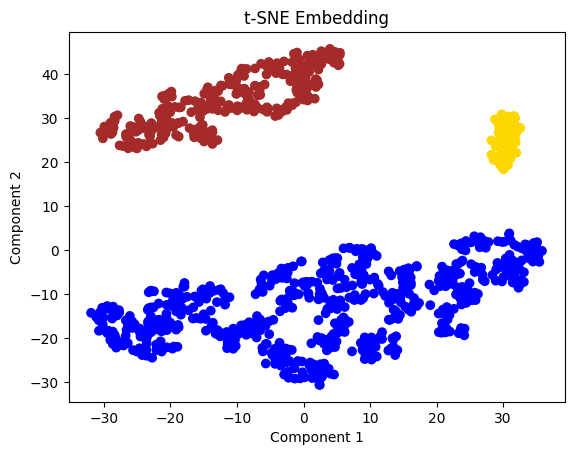

In [55]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_embedded = TSNE(n_components=2).fit_transform((pred_out[:,:5]))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=clust1)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Embedding')
plt.show()


In [18]:
pred_out.shape

(1000, 10)

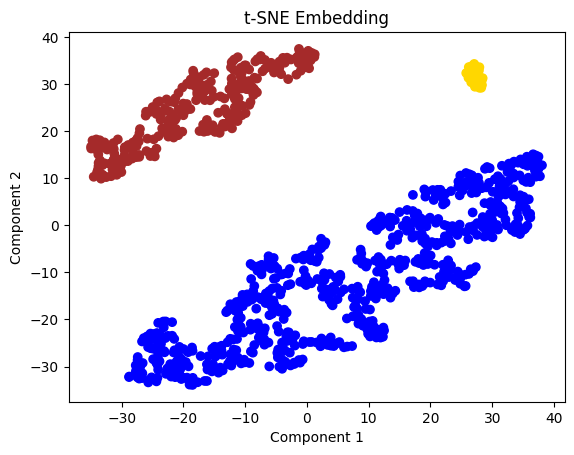

In [56]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_embedded = TSNE(n_components=2).fit_transform((pred_out[:,5:]))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=clust2)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Embedding')
plt.show()
